In [1]:
# !pip install pandas
# !pip install statsmodels
# !pip install matplotlib
#pip install skforecast
#!pip install seaborn
#pip install xgboost

## Importación Librerias

In [2]:
import pandas as pd
import requests
from io import BytesIO
from io import StringIO
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
import calendar
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from math import sqrt
from skforecast.model_selection import grid_search_forecaster
from datetime import datetime
from sklearn import metrics  # Para scikit-learn
from sklearn.model_selection import GridSearchCV
# from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow.keras.backend as K
import itertools

C:\Users\dhoyoso\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\dhoyoso\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Importación bases cliente

In [3]:
# URL del repositorio en GitHub
repo_url = 'https://api.github.com/repos/Pacheco-Carvajal/GPA-Data-ElectroDunas/contents/'

# Haz una solicitud GET a la API de GitHub para obtener la lista de archivos en el directorio
response = requests.get(repo_url)
file_data = response.json()

# Filtra los archivos que contienen "datos cliente" en su nombre
desired_files = [(file['download_url'], file['name']) for file in file_data if 'DATOSCLIENTE' in file['name']]

# Crea un DataFrame combinando todos los archivos encontrados
dfs = []
for file_url, file_name in desired_files:
    response = requests.get(file_url)
    content = response.content.decode('utf-8')
    df = pd.read_csv(StringIO(content))

    # Agrega una columna "fuente" con el nombre del archivo
    df['fuente'] = file_name

    dfs.append(df)

# Concatena los DataFrames en uno solo
result_df = pd.concat(dfs, ignore_index=True)

## Importación sector clientes

In [4]:
# URL cruda del archivo en GitHub
url = "https://github.com/Pacheco-Carvajal/GPA-Data-ElectroDunas/raw/main/sector_economico_clientes.xlsx"

# Cargar el archivo Excel en un DataFrame
sectores = pd.read_excel(url)

# Mostrar las primeras filas del DataFrame
sectores.head()

,Cliente:,Sector Económico:
0,Cliente 1,Elaboración de cacao y chocolate y de producto...
1,Cliente 2,Elaboración de cacao y chocolate y de producto...
2,Cliente 3,Elaboración de cacao y chocolate y de producto...
3,Cliente 4,Elaboración de cacao y chocolate y de producto...
4,Cliente 5,Elaboración de cacao y chocolate y de producto...


In [5]:
# Extraer los números de la columna 'fuente'
result_df['fuente'] = result_df['fuente'].str.extract('(\d+)')

# Concatenar 'Cliente' con los números extraídos
result_df['fuente'] = 'Cliente ' + result_df['fuente']

result_df.head()

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,fuente
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,Cliente 1
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,Cliente 1
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,Cliente 1
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,Cliente 1
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,Cliente 1


In [6]:
result_df = result_df.rename(columns={'fuente': 'Cliente'})
sectores = sectores.rename(columns={'Cliente:': 'Cliente'})
sectores['Cliente'] = sectores['Cliente'].str.strip()

In [7]:
result_df = pd.merge(result_df, sectores[['Cliente', 'Sector Económico:']], on='Cliente', how='left')
result_df.head()

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente,Sector Económico:
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,Cliente 1,Elaboración de cacao y chocolate y de producto...
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,Cliente 1,Elaboración de cacao y chocolate y de producto...
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,Cliente 1,Elaboración de cacao y chocolate y de producto...
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,Cliente 1,Elaboración de cacao y chocolate y de producto...
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,Cliente 1,Elaboración de cacao y chocolate y de producto...


In [8]:
result_df = result_df.rename(columns={'Sector Económico:': 'Sector Económico'})
result_df['Fecha'] = pd.to_datetime(result_df['Fecha'])
#Impuación a cero
result_df['Active_energy'] = result_df['Active_energy'].apply(lambda x: 0 if x < 0 else x)

In [9]:
# Suponiendo que 'result_df' es tu DataFrame y ya está cargado correctamente
# Asegúrate de que 'Fecha' está en formato de fecha si no está convertido aún
result_df['Fecha'] = pd.to_datetime(result_df['Fecha'])

In [10]:
# Calcula la media por cliente
media_por_cliente = result_df.groupby('Cliente')['Active_energy'].mean()

# Imputa los valores cero con la media correspondiente por cliente
result_df['Active_energy_ajustada'] = result_df.apply(lambda row: media_por_cliente[row['Cliente']] if row['Active_energy'] == 0 else row['Active_energy'], axis=1)

In [11]:
result_df_filtrado = result_df[result_df['Active_energy_ajustada'] == 0]
result_df_filtrado

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente,Sector Económico,Active_energy_ajustada


In [12]:
result_df

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente,Sector Económico,Active_energy_ajustada
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,Cliente 1,Elaboración de cacao y chocolate y de producto...,0.357841
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,Cliente 1,Elaboración de cacao y chocolate y de producto...,0.372264
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,Cliente 1,Elaboración de cacao y chocolate y de producto...,1.044687
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,Cliente 1,Elaboración de cacao y chocolate y de producto...,0.566425
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,Cliente 1,Elaboración de cacao y chocolate y de producto...,1.080556
...,...,...,...,...,...,...,...,...
463420,2023-03-31 20:00:00,0.231000,0.309493,1343.358528,1288.567372,Cliente 9,Cultivo de Árboles Frutales y Nueces,0.231000
463421,2023-03-31 21:00:00,0.041937,0.314091,1050.653622,1266.553989,Cliente 9,Cultivo de Árboles Frutales y Nueces,0.041937
463422,2023-03-31 22:00:00,0.231000,0.266937,1104.985834,991.259378,Cliente 9,Cultivo de Árboles Frutales y Nueces,0.231000
463423,2023-03-31 23:00:00,0.150296,0.312547,1284.048639,1091.283710,Cliente 9,Cultivo de Árboles Frutales y Nueces,0.150296


## Pruebas estacionariedad para MODEL- BASED

In [13]:
for cliente_id in range(1, 31): 
    # Filtrar el DataFrame para obtener solo las filas correspondientes a este cliente
    cliente_data = result_df[result_df['Cliente'] == f'Cliente {cliente_id}']
    
    # Aplicar la prueba de estacionariedad (ADF) a la serie temporal
    resultado_prueba = adfuller(cliente_data['Active_energy'])
    
    # Resultados de la prueba
    print(f"Cliente {cliente_id}:")
    print("Estadística ADF:", resultado_prueba[0])
    print("Valor p:", resultado_prueba[1])
    print("Valores críticos:", resultado_prueba[4])
    print("Conclusion:", "Los datos son estacionarios." if resultado_prueba[1] < 0.05 else "Los datos no son estacionarios.")
    print()

Cliente 1:
Estadística ADF: -4.174790013551806
Valor p: 0.0007267220985626516
Valores críticos: {'1%': -3.4306830865855864, '5%': -2.8616872124135067, '10%': -2.5668483571714216}
Conclusion: Los datos son estacionarios.

Cliente 2:
Estadística ADF: -4.491405477319599
Valor p: 0.00020379220684839077
Valores críticos: {'1%': -3.4306830865855864, '5%': -2.8616872124135067, '10%': -2.5668483571714216}
Conclusion: Los datos son estacionarios.

Cliente 3:
Estadística ADF: -4.301114208378335
Valor p: 0.000442242958565005
Valores críticos: {'1%': -3.4306830865855864, '5%': -2.8616872124135067, '10%': -2.5668483571714216}
Conclusion: Los datos son estacionarios.

Cliente 4:
Estadística ADF: -3.2227786360354123
Valor p: 0.018703448324354586
Valores críticos: {'1%': -3.4306830865855864, '5%': -2.8616872124135067, '10%': -2.5668483571714216}
Conclusion: Los datos son estacionarios.

Cliente 5:
Estadística ADF: -4.787967121562017
Valor p: 5.7343003032562675e-05
Valores críticos: {'1%': -3.430683086

In [14]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Crear un DataFrame vacío para almacenar los resultados
resultados_df = pd.DataFrame(columns=['Cliente', 'Estadística ADF', 'Valor p', 'Conclusion'])

# Iterar sobre los clientes
for cliente_id in range(1, 31):
    # Filtrar el DataFrame para obtener solo las filas correspondientes a este cliente
    cliente_data = result_df[result_df['Cliente'] == f'Cliente {cliente_id}']
    
    # Aplicar la prueba de estacionariedad (ADF) a la serie temporal
    resultado_prueba = adfuller(cliente_data['Active_energy'])
    
    # Determinar si los datos son estacionarios
    estacionario = "Estacionarios" if resultado_prueba[1] < 0.05 else "No estacionarios"
    
    # Guardar los resultados en el DataFrame
    resultados_df.loc[len(resultados_df)] = [cliente_id, resultado_prueba[0], resultado_prueba[1], estacionario]

# Mostrar el DataFrame con los resultados
resultados_df

,Cliente,Estadística ADF,Valor p,Conclusion
0,1,-4.174790,7.267221e-04,Estacionarios
1,2,-4.491405,2.037922e-04,Estacionarios
2,3,-4.301114,4.422430e-04,Estacionarios
3,4,-3.222779,1.870345e-02,Estacionarios
4,5,-4.787967,5.734300e-05,Estacionarios
5,6,-5.212425,8.292827e-06,Estacionarios
6,7,-5.275953,6.139918e-06,Estacionarios
7,8,-6.830971,1.894159e-09,Estacionarios
8,9,-3.127751,2.456652e-02,Estacionarios
9,10,-2.421805,1.356766e-01,No estacionarios


In [15]:
# resultados_df.to_excel('resultados_clientes.xlsx', index=False)

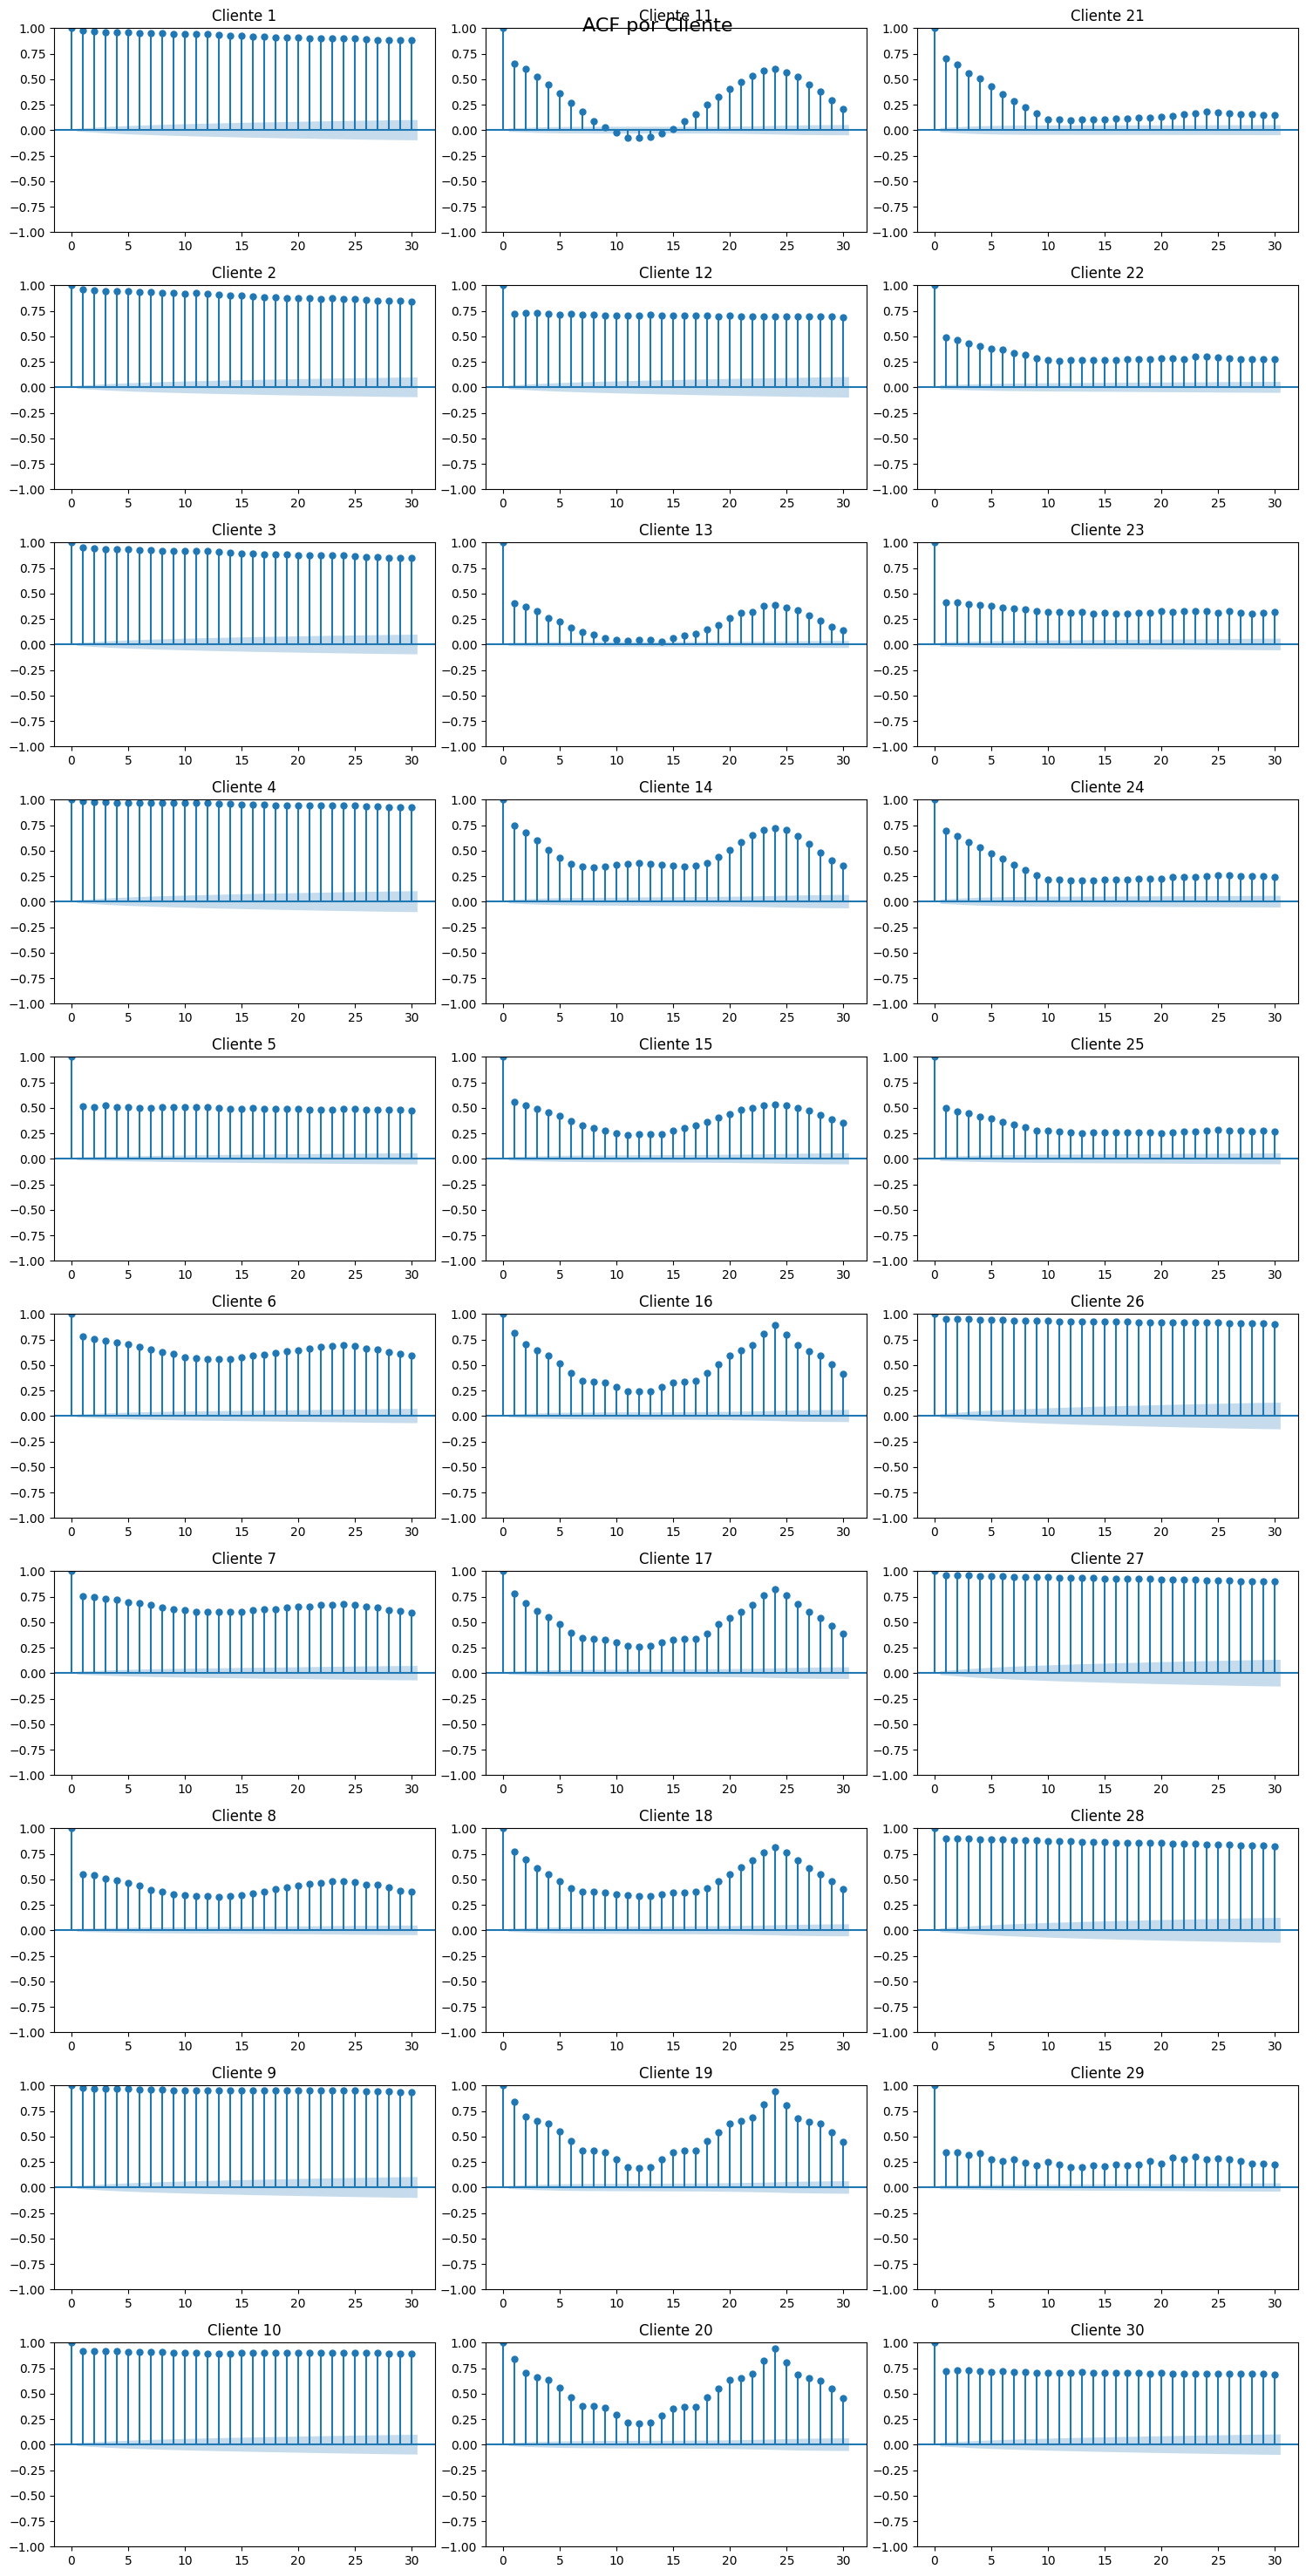

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
# Suponiendo que 'result_df' es tu DataFrame que contiene los datos de consumo de energía por cliente
fig, axes = plt.subplots(10, 3, figsize=(15, 30))
fig.suptitle('ACF por Cliente', fontsize=16)

for cliente_id in range(1, 31):
    # Calcular las coordenadas (fila, columna) en la grilla
    row = (cliente_id - 1) % 10
    col = (cliente_id - 1) // 10

    # Filtrar el DataFrame para obtener solo las filas correspondientes a este cliente
    cliente_data = result_df[result_df['Cliente'] == f'Cliente {cliente_id}']
    
    # Calcular la autocorrelación para la serie temporal de consumo de energía
    autocorrelation = pd.Series.autocorr(cliente_data['Active_energy'])
    
    # Graficar la función de autocorrelación
    plot_acf(cliente_data['Active_energy'], lags=30, ax=axes[row, col])
    axes[row, col].set_title(f'Cliente {cliente_id}')

# Ajustar el espacio entre los subplots
plt.tight_layout()
plt.show()

# Ejecucion con Energia Activa Random

In [17]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    return K.mean(K.abs((y_true - y_pred) / K.clip(K.abs(y_true), K.epsilon(), None))) * 100

In [18]:
# Definir función para evaluación métrica
def evaluacion_metrica(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Calcular métricas
    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    
    # Devolver métricas como un diccionario
    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    }

In [19]:
# Iterar sobre cada cliente ajustando parámetros
resultados_totales = []  # Lista para almacenar los resultados de todos los clientes

for numero_cliente in range(1, 31):
    cliente = 'Cliente ' + str(numero_cliente)
    cliente_df = result_df[result_df['Cliente'] == cliente].copy()
    
    # Ordenar los datos por fecha de manera ascendente
    cliente_df = cliente_df.sort_values(by='Fecha')
    
    # Obtener la columna de 'Active_energy' y establecer 'Fecha' como índice
    data_completa = cliente_df[['Fecha', 'Active_energy']]
    data_completa.set_index('Fecha', inplace=True)
    
    # Iterar sobre diferentes frecuencias y rezagos
    frecuencias = ['24H']
    n_back = [30]
    
    # Seleccionar solo el 90% de los datos
    data_completa = data_completa.iloc[:int(0.9 * len(data_completa))]

    # Crear una lista para almacenar los resultados
    resultados_cliente = []

    for frecuencia in frecuencias:
        # Resample los datos a la frecuencia especificada y sumar la energía activa
        data_completa_diaria = data_completa.resample(frecuencia).sum()

        # Reiniciar el índice para que 'Fecha' sea una columna nuevamente
        data_completa_diaria.reset_index(inplace=True)

        # Agregar columnas de mes y hora
        # data_completa_diaria['Month'] = data_completa_diaria['Fecha'].dt.month
        # data_completa_diaria['Hour'] = data_completa_diaria['Fecha'].dt.hour

        # Establecer el índice en 'Fecha' y la frecuencia
        data_completa_diaria.set_index('Fecha', inplace=True)
        data_completa_diaria.index.freq = frecuencia

        # Eliminar filas con valores NaN
        data_completa_diaria.dropna(inplace=True)

        #Bases LSTM
        dataindex= pd.to_datetime(data_completa_diaria.index)
        dt2= data_completa_diaria.to_numpy()
        close_data = dt2.reshape((-1,1))
        
        split_percent = 0.80
        split = int(split_percent*len(close_data))

        #Aplicamos dicha proporción a la definición de la parte de entrenamiento y de prueba.
        close_train = close_data[:split]
        close_test = close_data[split:]
        
        date_train = dataindex[:split]
        date_test = dataindex[split:]
                
        for rezago in n_back:
            train_generator = TimeseriesGenerator(close_train, close_train, length=rezago, batch_size=10) 
            test_generator = TimeseriesGenerator(close_test, close_test, length=rezago, batch_size=1)

            # Definir diferentes combinaciones de hiperparámetros
            neuronas = [200]
            f_activacion = ['tanh'] # ,'relu'
            num_epochs = [25]
 
            # Obtener todas las combinaciones de hiperparámetros
            param_combinations = itertools.product(neuronas, f_activacion, num_epochs)

            # Iterar sobre cada combinación de hiperparámetros
            for params in param_combinations:
                model = Sequential()
                model.add(
                    LSTM(params[0],  ## de nodos, dependerá de su poder de cómputo.
                         activation=params[1], #relu #función de activación.
                         input_shape=(rezago,1))   ##la longitud de la secuencia
                )
                model.add(Dense(1))  #capa de salida de predicción
                model.compile(optimizer='adam', loss=mean_absolute_percentage_error)
                
                # model.fit_generator(train_generator, epochs=num_epochs, verbose=0)
                model.fit(train_generator, epochs=params[2], verbose=0)
                
                history = model.fit(train_generator, epochs=params[2], verbose=0)

                #Predicción en el set de prueba:
                prediction = model.predict(test_generator)
                
                #El siguiente se emplea para pasar el tipo de datos de tensores a datos de una dimensión, aplicamos la función reshape.
                close_train = close_train.reshape((-1))
                close_test = close_test.reshape((-1))
                prediction = prediction.reshape((-1))
                selected_data = close_test[rezago:]

                # Evaluar métricas de rendimiento
                metricas = evaluacion_metrica(selected_data, prediction)
                
                # Almacenar resultados en la lista
                resultados_cliente.append({
                    'Cliente': cliente,
                    'Frecuencia': frecuencia,
                    'Rezago': rezago,
                    'Modelo': 'LSTM',
                    'Hiperparametros': params,
                    **metricas,  # Desempaquetar métricas como un diccionario
                    'Len_train': len(close_train),
                    'Len_test': len(prediction),
                    'Len_total': len(close_data)
                })

    # Agregar resultados de este cliente a la lista de resultados totales
    resultados_totales.extend(resultados_cliente)

# Convertir la lista de resultados en un DataFrame
resultados_df = pd.DataFrame(resultados_totales)

# Mostrar resultados
resultados_df

C:\Users\dhoyoso\AppData\Local\Temp\ipykernel_24304\4230183525.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_completa_diaria = data_completa.resample(frecuencia).sum()
C:\Users\dhoyoso\AppData\Local\Temp\ipykernel_24304\4230183525.py:38: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_completa_diaria.index.freq = frecuencia


KeyboardInterrupt: 

In [ ]:
resultados_df.to_excel('resultados_clientes_LSTM_no_imputing_frecuencias24Hlags30neurons200.xlsx', index=False)

In [ ]:
# Filtrar la información para un cliente específico (por ejemplo, 'Cliente 1')
cliente_seleccionado = 'Cliente 1'
resultados_cliente_seleccionado = resultados_df.query("Cliente == @cliente_seleccionado")

# Ordenar las filas según el MAPE de menor a mayor
resultados_cliente_seleccionado_ordenados = resultados_cliente_seleccionado.sort_values(by='MAPE')
resultados_cliente_seleccionado_ordenados

In [ ]:
# Iterar sobre cada cliente ajustando parámetros
resultados_totales = []  # Lista para almacenar los resultados de todos los clientes

for numero_cliente in range(1, 2):
    cliente = 'Cliente ' + str(numero_cliente)
    cliente_df = result_df[result_df['Cliente'] == cliente].copy()
    
    # Ordenar los datos por fecha de manera ascendente
    cliente_df = cliente_df.sort_values(by='Fecha')
    
    # Obtener la columna de 'Active_energy' y establecer 'Fecha' como índice
    data_completa = cliente_df[['Fecha', 'Active_energy_ajustada']]
    data_completa.set_index('Fecha', inplace=True)
    
    # Iterar sobre diferentes frecuencias y rezagos
    frecuencias = ['1H','8H', '12H']
    rezagos = [15,30]

    # Seleccionar solo el 90% de los datos
    data_completa = data_completa.iloc[:int(0.9 * len(data_completa))]

cliente_df

In [ ]:
# Iterar sobre cada cliente ajustando parámetros
resultados_totales = []  # Lista para almacenar los resultados de todos los clientes

for numero_cliente in range(1, 31):
    cliente = 'Cliente ' + str(numero_cliente)
    cliente_df = result_df[result_df['Cliente'] == cliente].copy()
    
    # Ordenar los datos por fecha de manera ascendente
    cliente_df = cliente_df.sort_values(by='Fecha')
    
    # Obtener la columna de 'Active_energy' y establecer 'Fecha' como índice
    data_completa = cliente_df[['Fecha', 'Active_energy_ajustada']]
    data_completa.set_index('Fecha', inplace=True)
    
    # Iterar sobre diferentes frecuencias y rezagos
    frecuencias = ['1H','8H', '12H']
    rezagos = [15,30]

    # Seleccionar solo el 90% de los datos
    data_completa = data_completa.iloc[:int(0.9 * len(data_completa))]

    # Crear una lista para almacenar los resultados
    resultados_cliente = []

    for frecuencia in frecuencias:
        # Resample los datos a la frecuencia especificada y sumar la energía activa
        data_completa_diaria = data_completa.resample(frecuencia).sum()

        # Reiniciar el índice para que 'Fecha' sea una columna nuevamente
        data_completa_diaria.reset_index(inplace=True)

        # Agregar columnas de mes y hora
        data_completa_diaria['Month'] = data_completa_diaria['Fecha'].dt.month
        data_completa_diaria['Hour'] = data_completa_diaria['Fecha'].dt.hour

        # Establecer el índice en 'Fecha' y la frecuencia
        data_completa_diaria.set_index('Fecha', inplace=True)
        data_completa_diaria.index.freq = frecuencia

        # Eliminar filas con valores NaN
        data_completa_diaria.dropna(inplace=True)

        for rezago in rezagos:
            # Crear columnas de rezagos para los datos
            data_completa_diaria[f'L{rezago}'] = data_completa_diaria['Active_energy_ajustada'].shift(rezago)

            # Eliminar filas con valores NaN
            data_completa_diaria.dropna(inplace=True)

            # Definir variables predictoras (X) y variable objetivo (Y)
            X = data_completa_diaria.iloc[:, 1:]
            Y = data_completa_diaria.iloc[:, 0]

            # Dividir datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

            # Definir diferentes combinaciones de hiperparámetros
            n_estimators_values = [100, 300, 500]
            max_depth_values = [10, 20, 30, None]
            min_samples_split_values = [2, 5, 10]
            min_samples_leaf_values = [1, 2, 4]
            bootstrap_values = [True, False]

            # Obtener todas las combinaciones de hiperparámetros
            param_combinations = itertools.product(n_estimators_values, max_depth_values, min_samples_split_values, min_samples_leaf_values, bootstrap_values)

            # Iterar sobre cada combinación de hiperparámetros
            for params in param_combinations:
                # Crear y entrenar modelo con la combinación de hiperparámetros
                modelo = RandomForestRegressor(n_estimators=params[0], max_depth=params[1], min_samples_split=params[2], min_samples_leaf=params[3], bootstrap=params[4], n_jobs=-1)
                modelo.fit(X_train, Y_train)

                # Hacer predicciones
                predictions = modelo.predict(X_test)

                # Evaluar métricas de rendimiento
                metricas = evaluacion_metrica(Y_test, predictions)
                
                # Almacenar resultados en la lista
                resultados_cliente.append({
                    'Cliente': cliente,
                    'Frecuencia': frecuencia,
                    'Rezago': rezago,
                    'Modelo': 'Random Forest',
                    'Hiperparametros': params,
                    **metricas,  # Desempaquetar métricas como un diccionario
                    'Len_train': len(X_train),
                    'Len_test': len(X_test),
                    'Len_total': len(data_completa_diaria)
                })

    # Agregar resultados de este cliente a la lista de resultados totales
    resultados_totales.extend(resultados_cliente)

# Convertir la lista de resultados en un DataFrame
resultados_df = pd.DataFrame(resultados_totales)

# Mostrar resultados
resultados_df

In [81]:
resultados_df.to_excel('resultados_clientes_Random_hiperparametros_imputado.xlsx', index=False)

In [ ]:
# # Graficar todas las columnas de combined_df
# combined_df.plot(subplots=True, figsize=(10, 10))
# plt.show()

combined_df.plot(figsize=(10, 6))
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Gráfico de todas las columnas')
plt.legend(loc='upper left')
plt.show()

